지금까지 훈련 세트에서 모델을 훈련하고 테스트 세트에서 모델을 평가하였다. 테스트 세트에서 얻어진 점수를 보고 모델의 성능을 가늠해 볼 수 있다. 즉 일반화 성능을 가늠해 볼 수 있다는 것이다.  
그런데 테스트 세트를 사용해 자꾸 성능을 확인하다 보면 점점 테스트 세트에 맞추게 된다.  
\
이전까지는 문제를 간단히 하려고 테스트 세트를 사용하였다. 하지만 테스트 세트로 일반화 성능을 올바르게 예측하려면 가능한 한 테스트 세트를 사용하지 말아야 한다. 모델을 만들고 나서 마지막에 딱 한 번만 사용하는 것이 좋다.  
그렇다면 max_depth 매개변수를 사용한 하이퍼파라미터 튜닝을 어떻게 할 수 있을까? 게다가 결정 트리는 테스트해 볼 매개변수가 많다.

### 검증 세트  
테스트 세트를 사용하지 않으면 모델이 과대적합인지 과소적합인지 판단하기 어렵다. 테스트 세트를 사용하지 않고 이를 측정하는 간단한 방법은 훈련 세트를 또 나누는 것이다. 이 데이터를 **검증 세트(validation set)**라고 부른다.  
단순한 방법이지만 많이 사용되는 방법이다. 1절에서 전체 데이터 중 20%를 테스트 세트로 만들고 나머지 80%를 훈련 세트로 만들었다. 이 훈련 세트 중에서 다시 20%를 떼어 내어 검증 세트로 만든다.  
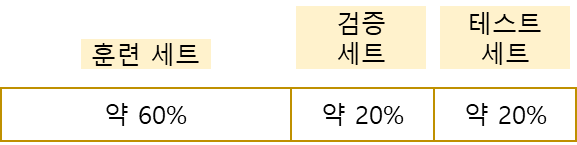

훈련 세트에서 모델을 훈련하고 검증 세트로 모델을 평가한다. 이런 식으로 테스트하고 싶은 매개변수를 바꾸어가며 가장 좋은 모델을 고른다. 그다음 이 매개변수를 사용해 훈련 세트와 검증 세트를 합쳐 훈련 데이터에서 모델을 다시 훈련한다. 그리고 마지막에 테스트 세트에서 최종 점수를 평가한다.  
아마도 실전에 투입했을 때의 테스트 세트의 점수와 비슷한 성능을 기대할 수 있을 것이다.  
\
이전 절에 사용했던 데이터를 다시 불러와서 검증 세트를 만들어 보자. 먼저 판다스로 CSV 데이터를 읽는다.

In [1]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')
print(wine) # 판다스로 읽은 데이터를 눈으로 익히자.

      alcohol  sugar    pH  class
0         9.4    1.9  3.51    0.0
1         9.8    2.6  3.20    0.0
2         9.8    2.3  3.26    0.0
3         9.8    1.9  3.16    0.0
4         9.4    1.9  3.51    0.0
...       ...    ...   ...    ...
6492     11.2    1.6  3.27    1.0
6493      9.6    8.0  3.15    1.0
6494      9.4    1.2  2.99    1.0
6495     12.8    1.1  3.34    1.0
6496     11.8    0.8  3.26    1.0

[6497 rows x 4 columns]


class 열을 타깃으로 사용하고 나머지 여은 특성 배열에 저장한다.

In [2]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()
print(data) # 넘파이 배열로 변환한 데이터를 눈으로 익히자.

[[ 9.4   1.9   3.51]
 [ 9.8   2.6   3.2 ]
 [ 9.8   2.3   3.26]
 ...
 [ 9.4   1.2   2.99]
 [12.8   1.1   3.34]
 [11.8   0.8   3.26]]


훈련 세트와 테스트 세트를 나눈다. 방식은 이전과 동일하다.

In [3]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
data, target, test_size = 0.2, random_state = 42)

train_input과 train_target을 다시 train_test_split() 함수에 넣어 훈련 세트 sub_input, sub_target과 검증 세트 val_input, val_target을 만든다.  
여기에서도 test_size 매개변수를 0.2로 지정하여 train_input의 20%를 val_input으로 만든다.

In [4]:
sub_input, val_input, sub_target, val_target = train_test_split(
train_input, train_target, test_size = 0.2, random_state = 42)

훈련 세트와 검증 세트의 크기를 확인해 보자.

In [5]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


원래 5197개였던 훈련 세트가 4157개로 줄고, 검증 세트는 1040개가 되었다.  
이제 sub_input, sub_target과 val_input, val_target을 사용해 모델을 만들고 평가해 보자.

In [6]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


이렇게 val_input, val_target을 사용해서 모델을 평가하면 된다. 이 모델은 훈련 모델에 과대적합되어 있다. 매개변수를 변경하여 더 좋은 모델을 생성해야 한다. 그 전에 검증 세트에 대해 더 알아보자.

#### 교차 검증  
검증 세트를 만들어서 훈련 세트가 줄어들었다. 보통 많은 데이터를 훈련에 사용할수록 좋은 모델이 생성된다. 그렇다고 검증 세트를 너무 조금 할당하면 검증 점수가 들쭉날쭉해지고 불안정하게 된다.  
**교차 검증(cross validation)**을 이용하면 안정적인 검증 점수를 얻고 훈련에 더 많은 데이터를 사용할 수 있다.  
\
교차 검증은 검증 세트를 떼어 내어 평가하는 과정을 여러 번 반복한다. 그다음 이 점수를 평균하여 최종 검증 점수를 얻는다. 이 과정은 아래의 그림으로 나타낼 수 있다.(아래는 3-폴드 교차 검증의 그림)  
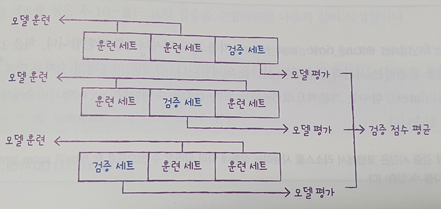  
  
3-폴드 교차 검증?  
훈련 세트를 세 부분으로 나눠서 교차 검증을 수행하는 것을 의미한다. 통칭 k-폴드 교차 검증(k-fold cross validation)이라고 하며, 훈련 세트를 몇 부분으로 나누냐에 따라 다르게 부른다. k-겹 교차 검증이라고도 부른다.

이해를 돕기 위해 3-폴드 교차 검증을 예시로 들었지만, 보통 5-폴드, 10-폴드 교차검증이 많이 사용된다. 이렇게 하면 데이터의 80 ~ 90%까지 훈련에 사용할 수 있다. 검증 세트가 줄어들지만 각 폴드에서 계산한 검증 점수를 평균하기 때문에 안정된 점수로 생각할 수 있다.

사이킷런에는 cross_validate()라는 교차 검증 함수가 있다. 먼저 평가할 모델 객체를 첫 번째 매개변수로 전달한다. 그다음 앞에서처럼 직접 검증 세트를 떼어 내지 않고 훈련 세트 전체를 cross_validate() 함수에 전달한다.  
사이킷런에는 cross_validate() 함수의 전신인 cross_val_score() 함수도 있으며 이 함수는 cross_validate() 함수의 결과 중에서 test_score() 값만 반환한다.

In [7]:
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.00999451, 0.0069952 , 0.00699615, 0.00699711, 0.00699544]), 'score_time': array([0.00099945, 0.00099945, 0.        , 0.00099921, 0.0009985 ]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


이 함수는 fit_time, score_time, test_score 키를 가진 딕셔너리를 반환한다. 처음 2개의 키는 각각 모델을 훈련하는 시간과 검증하는 시간을 의미한다. 각 키마다 5개의 숫자가 담겨있으며 cross_validate() 함수는 기본적으로 5-폴드 교차 검증을 수행한다. cv 매개변수에서 폴드 수를 바꿀 수도 있다.

교차 검증의 최종 점수는 test_score 키에 담긴 5개의 점수를 평균하여 얻을 수 있다. 이름은 test_score이지만 검증 폴드의 점수이다.

In [9]:
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487


주의할 점으로는 cross_validate()는 훈련 세트를 섞어 폴드를 나누지 않는다. 앞서 train_test_split() 함수로 전체 데이터를 섞은 후 훈련 세트를 준비했기 때문에 따로 섞을 필요가 없다. 하지만 만약 교차 검증을 할 때 훈련 세트를 섞으려면 분할기(splitter)를 지정해야 한다.  
\
사이킷런의 분할기는 교차 검증에서 폴드를 어떻게 나눌지 결정해 준다. cross_validate() 함수는 기본적으로 회귀 모델일 경우 KFold 분할기를 사용하고 분류 모델일 경우 타깃 클래스를 골고루 나누기 위해 StratifiedKfold를 사용한다.  
즉 앞서 수행한 교차 검증은 다음 코드와 동일하다.

In [10]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv = StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


만약 훈련 세트를 섞은 후 10-폴드 교차 검증을 수행하려면 다음과 같이 작성한다.

In [11]:
splitter = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
scores = cross_validate(dt, train_input, train_target, cv = splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


이어서 결정 트리의 매개변수 값을 바꿔가며 가장 좋은 성능이 나오는 모델을 찾아 보자. 이때 테스트 세트를 사용하지 않고 교차 검증을 통해서 좋은 모델을 고르면 된다.

### 하이퍼파라미터 튜닝  
머신러닝 모델이 학습하는 파라미터를 모델 파라미터라고 한다. 반면에 모델이 학습할 수 없어서 사용자가 지정해야만 하는 파라미터를 하이퍼파라미터라고 한다.  
사이킷런과 같은 머신러닝 라이브러리를 사용할 때 하이퍼파라미터는 모두 클래스나 메서드의 매개변수로 표현된다.  
\
하이퍼 파라미터를 튜닝하는 작업은 어떻게 진행할까? 먼저 라이브러리가 제공하는 기본값을 그대로 사용해 모델을 훈련한다. 그다음 검증 세트의 점수나 교차 검증을 통해서 매개변수를 조금씩 바꿔본다.  
모델마다 적게는 1 ~ 2개에서 많게는 5 ~ 6개의 매개변수를 제공한다. 이 매개변수를 바꿔가면서 모델을 훈련하고 교차 검증을 수행한다.

중요한 점이 있다. 결정 트리 모델에서 최적의 max_depth 값을 찾았다고 가정해 보자. 그다음 max_depth를 최적의 값으로 고정하고 min_samples_split 을 바꿔가며 최적을 값을 찾는다. 이렇게 한 매개변수의 최적값을 찾고 다른 매개변수의 최적값을 찾아도 될까?  
아니다. max_depth의 최적값은 min_samples_split 매개변수의 값이 바뀌면 함께 달라진다. 즉 이 두 매개변수를 동시에 바꿔가며 최적의 값을 찾아야 한다.  
\
게다가 매개변수가 많아지면 더욱 복잡해진다. 파이썬의 for 반복문으로 이런 과정을 직접 구현할 수도 있지만, 이미 만들어진 도구를 사용하면 편리하다. 사이킷런에서 제공하는 **그리드 서치(Grid Search)**를 사용한다.

사이킷런의 GridSearchCV 클래스는 하이퍼파라미터 탐색과 교차 검증을 한 번에 수행한다. 별도로 cross_validate() 함수를 호출할 필요가 없다. 어떻게 사용하는지 간단한 예를 만들어 보자. 기본 매개변수를 사용한 결정 트리 모델에서 min_impurity_decrease 매개변수의 최적값을 찾아 보자.  
먼저 GridSearchCV 클래스를 임포트하고 탐색할 매개변수와 탐색할 값의 리시트를 딕셔너리로 만든다.

In [12]:
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease' : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

여기서는 0.0001부터 0.0005까지 0.0001씩 증가하는 5개의 값을 시도한다. GridSearchCV 클래스에 탐색 대상 모델과 params 변수를 전달하여 그리드 서치 객체를 만든다.

In [20]:
gs = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, n_jobs = -1)

결정 트리 클래스의 객체를 생성하자마자 바로 전달했다. 그다음 일반 모델을 훈련하는 것처럼 gs 객체에 fit() 메서드를 호출한다. 이 메서드를 호출하면 그리드 서치 객체는 결정 트리 모델 min_impurity_decrease 값을 바꾸어가며 총 5번 실행한다.  
\
GridSearchCV의 cv 매개변수 기본값은 5이다. 따라서 min_impurity_decrease 값마다 5-폴드 교차 검증을 수행한다. 결국 5 × 5 = 25개의 모델을 훈련하게 된다. 많은 모델을 훈련하기 때문에 GridSearchCV 클래스의 n_jobs 매개변수에서 병렬 실행에 사용할 CPU코어 수를 지정하는 것이 좋다. 이 매개변수의 기본값은 1이고 -1로 지정하면 시스템에 있는 모든 코어를 사용한다.  
실행 결과는 중요하지 않아 건너뛴다.

In [21]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

교차 검증에서 최적의 하이퍼파라미터를 찾으면 전체 훈련 세트로 모델을 다시 만들어야하지만, 사이킷런의 그리드 서치는 훈련이 끝나면 25개 모델 중에서 검증 점수가 가장 높은 모델의 매개변수 조합으로 전체 훈련 세트에서 자동으로 다시 모델을 훈련한다.  
이 모델은 gs 객체의 best_estimator_ 속성에 저장되어 있다. 이 모델을 일반 결정 트리처럼 똑같이 사용할 수 있다.

In [22]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


그리드 서치로 찾은 최적의 매개변수는 best_params 속성에 저장되어 있다.

In [23]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


0.0001이 가장 좋은 값으로 선택되었다. 각 매개변수에서 수행한 교차 검증의 평균 점수는 cv_results_ 속성의 'mean_test_score'키에 저장되어 있다. 5번의 교차 검증으로 얻은 점수를 출력해 보자.

In [25]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


첫 번째 값이 가장 크다. 수동으로 고르는 것보다 넘파이 argmax() 함수를 사용하면 가장 큰 값의 인덱스를 추출할 수 있다. 그다음 이 인덱스를 사용하여 params 키에 저장된 매개변수를 출력할 수 있다.  
이 값이 최상의 검증 점수를 만든 매개변수 조합이다. 앞에서 출력한 gs.best_params와 동일한지 확인해 보자.

In [28]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


과정을 정리해보자.  
  
    1. 먼저 탐색할 매개변수를 지정한다.
    2. 그 다음 훈련 세트에서 그리드 서치를 수행하여 최상의 평균 검증 점수가 나오는 매개변수 조합을 찾는다. 이 조합은 그리드 서치 객체에 해당한다.
    3. 그리드 서치는 최상의 매개변수에서(교차 검증에 사용한 훈련 세트가 아니라) 전체 훈련 세트를 사용해 최종 모델을 훈련한다. 이 모델도 그리드 서치 객체에 저장된다.

조금 더 복잡한 매개변수 조합을 탐색해 보자.  
결정 트리에서 min_impurity_decrease는 노드를 분할하기 위한 불순도 감소 최소량을 지정한다. 여기에다가 max_depth로 트리의 깊이를 제한하고 min_samples_split으로 노드를 나누기 위한 최소 샘플수도 골라 보자.

In [30]:
params = {'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.0001),
         'max_depth' : range(5, 20, 1),
         'min_samples_split' : range(2, 100, 10)
         }


첫 번째 줄의 넘파이 arange() 함수는 첫 번째 매개변수 값에서 시작하여 두 번째 매개변수에 도달할 때까지 세 번째 매개변수를 계속 더한 배열을 만든다. 코드에서는 0.0001에서 시작하여 0.001이 될 때까지 0.0001을 계속 더한 배열이다. 두 번째 매개변수는 포함되지 않으므로 배열의 원소는 총 9개이다.  
\
파이썬 range() 함수도 비슷하다. 하지만 이 함수는 정수만 사용할 수 있다. 이 경우 max_depth를 5에서 20까지 1씩 증가하면서 15개의 값을 만든다. min_samples_split은 2에서 100까지 10씩 증가하면서 10개의 값을 만든다.  
  
따라서 이 매개변수로 수행할 교차 검증 횟수는 9 × 15 × 10 = 1350개이다. 기본 5-폴드 교차 검증을 수행하므로 만들어지는 모델의 수는 6750개나 된다. n_jobs 매개변수를 -1로 설정하고 그리드 서치를 실행해 보자.

In [32]:
gs = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, n_jobs = -1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

최상의 매개변수 조합을 확인해 보자.

In [33]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


최상의 교차 검증 점수도 확인해 보자.

In [34]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


GridSearchCV 클래스를 사용하니 매개변수를 일일이 바꿔가며 교차 검증을 수행하지 않고 원하는 매개변수 값을 나열하면 자동으로 교차 검증을 수행해서 최상의 매개변수를 찾을 수 있다.  
하지만 앞에서 탐색할 매개변수의 간격을 0.0001 혹은 1로 설정했는데 이렇게 간격을 둔 것에 특별한 근거가 없다. 이보다 더 좁거나 넓은 간격으로 시도해 볼 수 있지 않을까?

#### 랜덤 서치  
매개변수의 값이 수치일 때 값의 범위나 간격을 미리 정하기 어려울 수 있다. 또 너무 많은 매개변수 조건이 있어 그리스 서치 수행 시간이 오래 걸릴 수 있다. 이럴 때 **랜덤 서치(Random Search)**를 사용하면 좋다.  
랜덤 서치에는 매개변수 값의 목록을 전달하는 것이 아니라 매개변수를 샘플링할 수 있는 확률 분포 객체를 전달한다. 확률 분포가 무엇인지는 먼저 싸이파이에서 2개의 확률 분포 클래스를 임포트해 보자.

싸이파이(scipy) 라이브러리란?  
싸이파이는 파이썬의 핵심 과학 라이브러리 중 하나이다. 적분, 보간, 선형 대수, 확률 등을 포함한 수치 계산 전용 라이브러리이다. 사이킷런은 넘파이와 싸이파이 기능을 많이 사용한다.

In [35]:
from scipy.stats import uniform, randint

싸이파이의 stats 서브 패키지에 있는 uniform과 randint 클래스는 모두 주어진 범위에서 고르게 값을 뽑는다. 이를 '균등 분포에서 샘플링한다'라고 말한다. randint는 정숫값을 뽑고, uniform은 실숫값을 뽑는다. 사용하는 방법은 같다. 0에서 10 사이의 범위를 갖는 randint 객체를 만들고 10개의 숫자를 샘플링해 보자.

In [36]:
rgen = randint(0, 10)
rgen.rvs(10)

array([4, 5, 8, 7, 2, 2, 5, 6, 5, 0])

10개밖에 되지 않기 때문에 고르게 샘플링되는 것 같지 않지만 샘플링 숫자를 늘리면 쉽게 확인이 가능하다. 1000개를 샘플링해서 각 숫자의 개수를 세어 보자.

In [41]:
np.unique(rgen.rvs(1000), return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 91,  86, 104, 121, 101, 102, 110,  98,  94,  93], dtype=int64))

개수가 늘어나니 0에서 9까지의 숫자가 어느 정도 고르게 추출되었다. uniform 클래스의 사용법도 동일하다. 0 ~ 1 사이에서 10개의 실수를 추출해 보자.

In [42]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.37521456, 0.81796021, 0.00965437, 0.94668261, 0.10898501,
       0.96571604, 0.86121908, 0.33377399, 0.02721848, 0.94852683])

랜덤 서치에 randint와 uniform 클래스 객체를 넘겨주고 총 몇 번을 샘플링해서 최적의 매개변수를 찾으라고 명령할 수 있다. 샘플링 횟수는 시스템 자원이 허락하는 범위 내에서 최대한 크게 하는 것이 좋다.  
\
그럼 탐색할 매개변수의 딕셔너리를 만들어 보자. 여기에서는 min_samples_leaf 매개변수를 탐색 대상에 추가한다. 이 매개변수는 리프 노드가 되기 위한 최소 샘플의 개수이다. 어떤 노드가 분할하여 만들어질 자식 노드의 샘플 수가 이 값보다 작을 경우 분할하지 않는다. 탐색할 매개변수 범위는 다음과 같다.

In [50]:
params = {'min_impurity_decrease' : uniform(0.0001, 0.001),
         'max_depth' : randint(20, 50),
         'min_samples_split' : randint(2, 25),
         'min_samples_leaf' : randint(1, 25)
         }


min_impurity_decrease는 0.0001에서 0.001 사이의 실숫값을 샘플링한다. max_depth는 20에서 50 사이의 정수, min_samples_split은 2에서 25 사이의 정수, min_samples_leaf는 1에서 25 사이의 정수를 샘플링한다. 샘플링 횟수는 사이킷런의 랜덤 서치 클래스인 RandomizedSearchCV의 n_iter 매개변수에 지정한다.

In [51]:
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state = 42), params, n_iter = 100, 
                       n_jobs = -1, random_state = 42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002581AFC60A0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002581AFBC850>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002581AFC6220>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002581AFBCAF0>},
                   random_state=42)

위 params에 정의된 매개변수 범위에서 총 100번(n_iter 매개변수)을 샘플링하여 교차 검증을 수행하고 최적의 매개변수 조합을 찾는다. 앞서 그리드 서치보다 훨씬 교차 검증 수를 줄이면서 넓은 영역을 효과적으로 탐색할 수 있다. 결과를 확인해 보자. 먼저 최적의 매개변수 조합을 출력해 보자.

In [52]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


최고의 교차 검증 점수도 확인해 보자.

In [53]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


최적의 모델은 이미 전체 훈련 세트(train_input, train_target)로 훈련되어 best_estimator_ 속성에 저장되어 있다. 이 모델을 최종 모델로 결정하고 테스트 세트의 성능을 확인해 보자.

In [54]:
dt = gs.best_estimator_
print(dt.score(test_input, test_target))

0.86


테스트 세트는 검증 세트에 비해 점수가 조금 작은 것이 일반적이다. 테스트 세트 점수가 아주 높지는 않지만 충분히 다양한 매개변수를 테스트 해서 얻은 결과이다.  
\
앞으로 수동으로 매개변수를 바꾸는 대신에, 그리드 서치나 랜덤 서치를 사용할 수 있다.

- **검증 세트**  
    하이퍼파라미터 튜닝을 위해 모델을 평가할 때, 테스트 세트를 사용하지 않기 위해 훈련 세트에서 다시 떼어 낸 데이터 세트이다.  
  
  
- **교차 검증**  
    훈련 세트를 여러 폴드로 나눈 다음 한 폴드가 검증 세트의 역할을 하고 나머지 폴드에서는 모델을 훈련한다. 교차 검증은 이런 식으로 모든 폴드에 대해 검증 점수를 얻어 평균하는 방법이다.  
  
  
- **그리드 서치**  
    하이퍼파라미터 탐색을 자동화해 주는 도구이다. 탐색할 매개변수를 나열하면 교차 검증을 수행하여 가장 좋은 검증 점수의 매개변수 조합을 선택한다. 마지막으로 이 매개변수의 조합으로 최종 모델을 훈련한다.  
    
    
- **랜덤 서치**  
    연속된 매개변수 값을 탐색할 때 유용하다. 탐색할 값을 직접 나열하는 것이 아닌 탐색 값을 샘플링할 수 있는 확률 분포 객체를 전달한다. 지정된 횟수만큼 샘플링하여 교차 검증을 수행하기 때문에 시스템 자원이 허락하는 만큼 탐색량을 조절할 수 있다.

### scikit-learn  
- **cross_validate**는 교차 검증을 수행하는 함수이다.  
  
    <font color=blue>첫 번째</font> 매개변수에 교차 검증을 수행할 모델 객체를 전달한다.  
    <font color=blue>두 번째</font> 매개변수에 특성  
    <font color=blue>세 번째</font> 매개변수에 타깃 데이터 를 전달한다.  
  
    <font color=blue>scoring</font> 매개변수에 검증에 사용할 평가 지표를 지정할 수 있다. 기본적으로 분류 모델은 정확도를 의미하는 'accuracy', 회귀 모델은 결정계수를 의미하는 'r2'가 된다.  
  
    <font color=blue>cv</font> 매개변수에 교차 검증 폴드 수나 스플리터 객체를 지정할 수 있다. 기본값은 5이다. 회귀일 때는 KFold 클래스를 사용하고 분류일 때는 StratifiedKFold 클래스를 사용하여 5-폴드 교차 검증을 수행한다.  
  
    <font color=blue>n_jobs</font> 매개변수는 교차 검증을 수행할 때 사용할 CPU 코어 수를 지정한다. 기본값은 1로 하나의 코어를 사용한다. -1로 지정하면 시스템에 있는 모든 코어를 사용한다.  
  
    <font color=blue>return_train_score</font> 매개변수를 True로 지정하면 훈련 세트의 점수도 반환한다. 기본값은 False이다.  
  
  
- **GridSearchCV**는 교차 검증으로 하이퍼파라미터 탐색을 수행한다.  
  
    <font color=blue>첫 번째</font> 매개변수로 그리드 서치를 수행할 모델 객체를 전달한다.  
    <font color=blue>두 번째</font> 매개변수에는 탐색할 모델의 매개변수와 값을 전달한다.  
  
    <font color=blue>scoring, cv, n_jobs, return_train_score</font> 매개변수는 cross_validate() 함수와 동일하다.  
  
- **RandomizedSearchCV**는 교차 검증으로 랜덤한 하이퍼파라미터 탐색을 수행한다. 최상의 모델을 찾은 후 훈련 세트 전체를 사용해 최종 모델을 훈련한다.  
  
    <font color=blue>첫 번째</font> 매개변수로 그리드 서치를 수행할 모델 객체를 전달한다.  
    <font color=blue>두 번째</font> 매개변수에는 탐색할 모델의 매개변수와 확률 분포 객체를 전달한다.  
  
    <font color=blue>scoring, cv, n_jobs, return_train_score</font> 매개변수는 cross_validate() 함수와 동일하다.

마지막 RandomizedSearchCV 예제에서 DecisionTreeClassifier 클래스에 splitter = 'random' 매개변수를 추가하고 다시 훈련해 보자. splitter 매개변수의 기본값은 'best'로 각 노드에서 최선의 분할을 찾는다. 'random'이면 무작위로 분할한 다음 가장 좋은 것을 고른다.  
왜 이런 옵션이 필요한지는 다음 절에서 알 수 있다. 테스트 세트에서 성능이 올라갔는가? 내려갔는가?

In [59]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter = 'random', random_state = 42), params, n_iter = 100,
                       n_jobs = -1, random_state = 42)
gs.fit(train_input, train_target)
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))
dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': 0.00011407982271508446, 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077


결정 트리의 노드를 랜덤하게 분할하기 때문에 100번의 반복에서 최적의 매개변수 조합을 찾지 못했다. 평균 검증 점수와 테스트 세트의 점수가 모두 조금 낮다.